In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# 👉 Path to your CSV file in Google Drive
csv_path = '/content/drive/MyDrive/pakistan_tomato_disease_forecast4000.csv'

print("CSV exists:", os.path.exists(csv_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV exists: True


In [ ]:
import os
import pandas as pd

# Path to your CSV file in Google Drive
csv_path = '/content/drive/MyDrive/pakistan_tomato_disease_forecast4000.csv'

# Make a folder to store processed data (optional)
extract_dir = '/content/weather_data'
os.makedirs(extract_dir, exist_ok=True)

# Check file exists
print("CSV exists:", os.path.exists(csv_path))

# Load CSV directly (NO extraction needed)
df = pd.read_csv(csv_path)

print("CSV loaded successfully!")
print("Rows:", len(df))
print("Columns:", df.columns.tolist())

# (Optional) save a copy inside extract_dir
df.to_csv(os.path.join(extract_dir, 'dataset_copy.csv'), index=False)

print("Saved a copy to:", extract_dir)


CSV exists: True
CSV loaded successfully!
Rows: 14610
Columns: ['date', 'tmax', 'tmin', 'rain', 'rhmax', 'rhmin', 'solar', 'wind', 'city', 'tmean', 'rhmean', 'LeafWetness_est', 'LateBlight_Risk', 'EarlyBlight_Risk', 'BacterialSpot_Risk', 'MosaicVirus_Risk', 'YellowVirus_Risk', 'LeafMold_Risk', 'Septoria_Risk']
Saved a copy to: /content/weather_data


In [ ]:
import pandas as pd
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')

# 👉 Use your actual CSV file path
csv_path = '/content/drive/MyDrive/pakistan_tomato_disease_forecast4000.csv'

# Load the CSV file
df = pd.read_csv(csv_path)

print("✅ Dataset loaded! Shape:", df.shape)
df.head()


✅ Dataset loaded! Shape: (14610, 19)


,date,tmax,tmin,rain,rhmax,rhmin,solar,wind,city,tmean,rhmean,LeafWetness_est,LateBlight_Risk,EarlyBlight_Risk,BacterialSpot_Risk,MosaicVirus_Risk,YellowVirus_Risk,LeafMold_Risk,Septoria_Risk
0,2021-01-01,16.2,5.0,0.0,96,52,12.08,9.5,Lahore,10.60,74.0,0,Low,Low,Low,Low,Low,Low,Low
1,2021-01-02,16.1,3.7,2.6,100,59,9.51,11.7,Lahore,9.90,79.5,1,Low,Low,Low,Low,Low,Low,Low
2,2021-01-03,18.0,10.2,2.4,95,69,7.90,15.3,Lahore,14.10,82.0,1,Low,Low,Low,Low,Low,Low,Low
3,2021-01-04,19.6,12.4,11.2,97,68,7.87,15.5,Lahore,16.00,82.5,1,Medium,Low,Low,Low,Low,Low,Low
4,2021-01-05,16.3,13.8,23.1,95,90,3.34,20.5,Lahore,15.05,92.5,1,High,Low,Low,Low,Low,Low,Low


In [ ]:
# Convert and sort by date to avoid leakage
# Ensure the column exists
if 'date' not in df.columns:
    print("❌ ERROR: Your dataset does NOT contain a 'date' column.")
    print("Available columns:", df.columns.tolist())
else:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.sort_values(by='date').reset_index(drop=True)
    print("✅ Date column converted and dataset sorted!")

# Target disease risk columns
target_cols = [
    'LateBlight_Risk','EarlyBlight_Risk','BacterialSpot_Risk',
    'MosaicVirus_Risk','YellowVirus_Risk','LeafMold_Risk','Septoria_Risk'
]

# Check missing columns
missing = [col for col in target_cols if col not in df.columns]

if missing:
    print("❌ ERROR: These target columns are missing:", missing)
    print("Available columns:", df.columns.tolist())
else:
    print("Target columns found:", target_cols)
    print(df[target_cols].head())


✅ Date column converted and dataset sorted!
Target columns found: ['LateBlight_Risk', 'EarlyBlight_Risk', 'BacterialSpot_Risk', 'MosaicVirus_Risk', 'YellowVirus_Risk', 'LeafMold_Risk', 'Septoria_Risk']
  LateBlight_Risk EarlyBlight_Risk BacterialSpot_Risk MosaicVirus_Risk  \
0             Low              Low                Low              Low   
1             Low              Low                Low              Low   
2             Low              Low                Low              Low   
3             Low              Low                Low              Low   
4             Low              Low                Low              Low   

  YellowVirus_Risk LeafMold_Risk Septoria_Risk  
0              Low           Low           Low  
1              Low           Low           Low  
2              Low           Low           Low  
3              Low           Low           Low  
4              Low           Low           Low  


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

# ---- Encode city column safely ----
if 'city' not in df.columns:
    print("❌ ERROR: Your dataset does NOT contain a 'city' column.")
    print("Available columns:", df.columns.tolist())
else:
    city_encoder = LabelEncoder()
    df['city'] = city_encoder.fit_transform(df['city'])
    print("✅ City encoding done!")

# ---- Features and Targets ----
missing_targets = [c for c in target_cols if c not in df.columns]

if missing_targets:
    print("❌ ERROR: Missing target columns:", missing_targets)
    print("Available columns:", df.columns.tolist())
else:
    X = df.drop(columns=target_cols + ['date'], errors='ignore')
    y = df[target_cols]

    print("\n✅ Feature columns:", X.columns.tolist())
    print("\nExample feature row:")
    display(X.head(1))


✅ City encoding done!

✅ Feature columns: ['tmax', 'tmin', 'rain', 'rhmax', 'rhmin', 'solar', 'wind', 'city', 'tmean', 'rhmean', 'LeafWetness_est']

Example feature row:


,tmax,tmin,rain,rhmax,rhmin,solar,wind,city,tmean,rhmean,LeafWetness_est
0,16.2,5.0,0.0,96,52,12.08,9.5,3,10.6,74.0,0


In [ ]:
encoders = {}
y_encoded = pd.DataFrame()

# Check all target columns exist
missing_targets = [c for c in target_cols if c not in df.columns]
if missing_targets:
    print("❌ ERROR: These target columns are missing:", missing_targets)
else:
    print("✅ All target columns found!")

# Encode each target column
for col in target_cols:
    le = LabelEncoder()

    # Check for NaN values
    if y[col].isna().sum() > 0:
        print(f"⚠️ WARNING: Missing values found in {col}. Filling with 'Unknown'")
        y[col] = y[col].fillna("Unknown")

    # Fit + transform
    y_encoded[col] = le.fit_transform(y[col])
    encoders[col] = le

print("\n✅ Encoded targets sample:")
y_encoded.head()


✅ All target columns found!

✅ Encoded targets sample:


,LateBlight_Risk,EarlyBlight_Risk,BacterialSpot_Risk,MosaicVirus_Risk,YellowVirus_Risk,LeafMold_Risk,Septoria_Risk
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1


In [ ]:
# --- Time-based split (ensure df is sorted by date first) ---
if 'date' not in df.columns:
    print("❌ ERROR: 'date' column missing. Cannot do time-based split.")
else:
    df = df.sort_values('date').reset_index(drop=True)

# Ensure X and y_encoded exist
if 'X' not in locals() or 'y_encoded' not in locals():
    raise Exception("❌ ERROR: X or y_encoded not created before splitting.")

# --- Train/Test Split ---
split_index = int(0.8 * len(df))

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y_encoded.iloc[:split_index]
y_test  = y_encoded.iloc[split_index:]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# --- Fix missing values to avoid StandardScaler errors ---
X_train = X_train.fillna(0)
X_test  = X_test.fillna(0)

# --- Standard Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Save scaler
scaler_path = '/content/drive/MyDrive/weather_scaler.pkl'
joblib.dump(scaler, scaler_path)

print(f"✅ Scaler saved to {scaler_path}")


Train shape: (11688, 11) Test shape: (2922, 11)
✅ Scaler saved to /content/drive/MyDrive/weather_scaler.pkl


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

input_dim = X_train_scaled.shape[1]
inputs = layers.Input(shape=(input_dim,))

# ----- Shared Feature Extractor -----
x = layers.Dense(128, activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# ----- Output heads (one per disease) -----
outputs = {
    col: layers.Dense(3, activation='softmax', name=col)(x)
    for col in target_cols
}

model = models.Model(inputs=inputs, outputs=outputs)

# ----- Prepare y as a dictionary of individual columns -----
y_train_dict = {col: y_train[col] for col in target_cols}
y_test_dict  = {col: y_test[col] for col in target_cols}

# ----- Compile the model -----
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={col: 'sparse_categorical_crossentropy' for col in target_cols},
    metrics={col: 'accuracy' for col in target_cols}
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      1,536 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BacterialSpot_Risk  │ (None, 3)         │        195 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EarlyBlight_Risk    │ (None, 3)         │        195 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LateBlight_Risk     │ (None, 3)         │        195 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LeafMold_Risk       │ (None, 3)         │        195 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MosaicVirus_Risk    │ (None, 3)         │        195 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Septoria_Risk       │ (None, 3)         │        195 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ YellowVirus_Risk    │ (None, 3)         │        195 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,925 (46.58 KB)

 Trainable params: 11,541 (45.08 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Prepare y as list of arrays (one per output)
y_train_list = [y_train[col].values for col in target_cols]
y_test_list  = [y_test[col].values for col in target_cols]

# Callbacks
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train model
history = model.fit(
    X_train_scaled,
    y_train_list,
    validation_data=(X_test_scaled, y_test_list),
    epochs=80,
    batch_size=32,
    callbacks=[lr_scheduler, early_stop],
    verbose=1
)


Epoch 1/80
366/366 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - BacterialSpot_Risk_accuracy: 0.5605 - BacterialSpot_Risk_loss: 1.0264 - EarlyBlight_Risk_accuracy: 0.5500 - EarlyBlight_Risk_loss: 1.1023 - LateBlight_Risk_accuracy: 0.5630 - LateBlight_Risk_loss: 1.1056 - LeafMold_Risk_accuracy: 0.5694 - LeafMold_Risk_loss: 0.9897 - MosaicVirus_Risk_accuracy: 0.7120 - MosaicVirus_Risk_loss: 0.7383 - Septoria_Risk_accuracy: 0.6109 - Septoria_Risk_loss: 0.9773 - YellowVirus_Risk_accuracy: 0.5886 - YellowVirus_Risk_loss: 0.9939 - loss: 6.9334 - val_BacterialSpot_Risk_accuracy: 0.9795 - val_BacterialSpot_Risk_loss: 0.0680 - val_EarlyBlight_Risk_accuracy: 0.9521 - val_EarlyBlight_Risk_loss: 0.1397 - val_LateBlight_Risk_accuracy: 0.9507 - val_LateBlight_Risk_loss: 0.1506 - val_LeafMold_Risk_accuracy: 0.8511 - val_LeafMold_Risk_loss: 0.4282 - val_MosaicVirus_Risk_accuracy: 0.8361 - val_MosaicVirus_Risk_loss: 0.4626 - val_Septoria_Risk_accuracy: 0.9295 - val_Septoria_Risk_loss: 0.1783 - val_YellowVirus_R

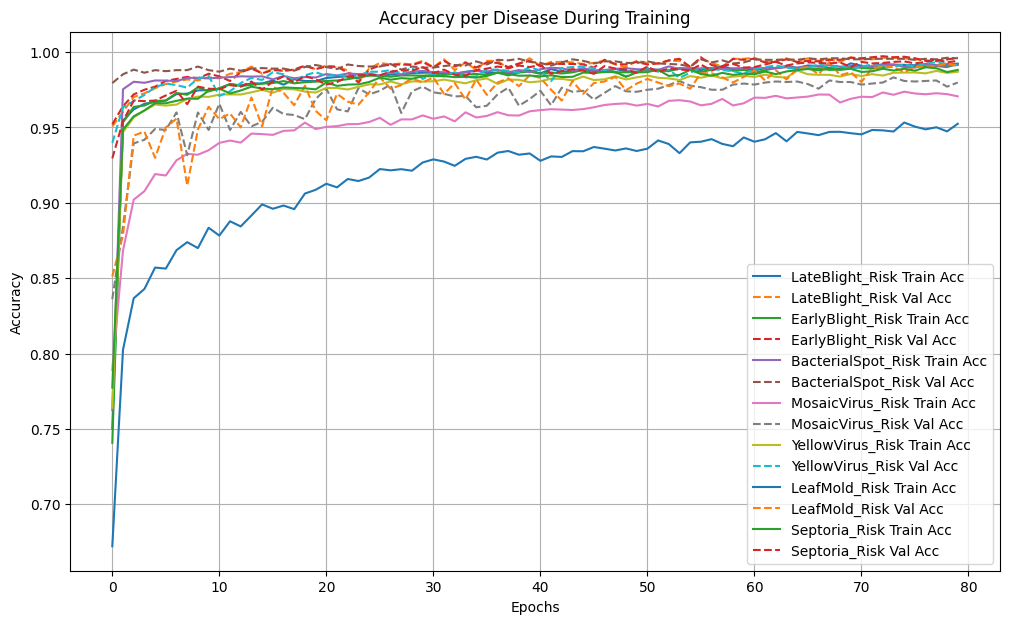

In [ ]:
plt.figure(figsize=(12,7))

for col in target_cols:
    train_key = f'{col}_accuracy'
    val_key = f'val_{col}_accuracy'

    # Check if metric exists in history
    if train_key in history.history:
        plt.plot(history.history[train_key], label=f'{col} Train Acc')
    if val_key in history.history:
        plt.plot(history.history[val_key], linestyle='--', label=f'{col} Val Acc')

plt.title("Accuracy per Disease During Training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(type(y_pred_probs))
print(model.output_names)
print([np.array(arr).shape for arr in y_pred_probs])


<class 'dict'>
ListWrapper(['BacterialSpot_Risk', 'EarlyBlight_Risk', 'LateBlight_Risk', 'LeafMold_Risk', 'MosaicVirus_Risk', 'Septoria_Risk', 'YellowVirus_Risk'])
[(), (), (), (), (), (), ()]


In [ ]:
# Predict -> dict output
y_pred_probs = model.predict(X_test_scaled)

# Convert softmax -> class indices
y_pred = {}
for col in target_cols:
    y_pred[col] = np.argmax(y_pred_probs[col], axis=1)

# Evaluate
from sklearn.metrics import classification_report

for col in target_cols:
    print(f"\n📈 {col}:")
    print(classification_report(
        y_test[col],
        y_pred[col],
        target_names=encoders[col].classes_
    ))


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

📈 LateBlight_Risk:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         0
         Low       1.00      0.95      0.97      2860
      Medium       0.02      0.02      0.02        62

    accuracy                           0.93      2922
   macro avg       0.34      0.32      0.33      2922
weighted avg       0.98      0.93      0.95      2922


📈 EarlyBlight_Risk:
              precision    recall  f1-score   support

        High       0.90      1.00      0.94       128
         Low       1.00      0.99      1.00      2739
      Medium       0.96      1.00      0.98        55

    accuracy                           0.99      2922
   macro avg       0.95      1.00      0.97      2922
weighted avg       0.99      0.99      0.99      2922


📈 BacterialSpot_Risk:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00       123
         Low       0.96   

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("\n================ REGRESSION-STYLE METRICS (on encoded risk levels) ================\n")

reg_results = []

class_values = np.array([0, 1, 2], dtype=float)

for col in target_cols:

    y_true_num = y_test[col].values
    y_pred_class = y_pred[col]
    y_pred_score = (y_pred_probs[col] * class_values).sum(axis=1)

    # Hard metrics
    mae_hard = mean_absolute_error(y_true_num, y_pred_class)
    rmse_hard = np.sqrt(mean_squared_error(y_true_num, y_pred_class))
    r2_hard = r2_score(y_true_num, y_pred_class)

    # Soft metrics
    mae_soft = mean_absolute_error(y_true_num, y_pred_score)
    rmse_soft = np.sqrt(mean_squared_error(y_true_num, y_pred_score))
    r2_soft = r2_score(y_true_num, y_pred_score)

    print(f"📊 {col} (Low=0, Medium=1, High=2)")
    print(f"  Hard predictions:")
    print(f"    MAE  = {mae_hard:.4f}")
    print(f"    RMSE = {rmse_hard:.4f}")
    print(f"    R²   = {r2_hard:.4f}")
    print(f"  Soft predictions (probability-weighted):")
    print(f"    MAE  = {mae_soft:.4f}")
    print(f"    RMSE = {rmse_soft:.4f}")
    print(f"    R²   = {r2_soft:.4f}\n")



================ REGRESSION-STYLE METRICS (on encoded risk levels) ================

📊 LateBlight_Risk (Low=0, Medium=1, High=2)
  Hard predictions:
    MAE  = 0.0876
    RMSE = 0.3549
    R²   = -5.0642
  Soft predictions (probability-weighted):
    MAE  = 0.0859
    RMSE = 0.3410
    R²   = -4.6006

📊 EarlyBlight_Risk (Low=0, Medium=1, High=2)
  Hard predictions:
    MAE  = 0.0058
    RMSE = 0.0763
    R²   = 0.9062
  Soft predictions (probability-weighted):
    MAE  = 0.0108
    RMSE = 0.0646
    R²   = 0.9327

📊 BacterialSpot_Risk (Low=0, Medium=1, High=2)
  Hard predictions:
    MAE  = 0.0832
    RMSE = 0.3466
    R²   = -0.9324
  Soft predictions (probability-weighted):
    MAE  = 0.0821
    RMSE = 0.3358
    R²   = -0.8138

📊 MosaicVirus_Risk (Low=0, Medium=1, High=2)
  Hard predictions:
    MAE  = 0.8323
    RMSE = 1.1825
    R²   = -1.4090
  Soft predictions (probability-weighted):
    MAE  = 0.8040
    RMSE = 1.1503
    R²   = -1.2794

📊 YellowVirus_Risk (Low=0, Medium=1, Hi

In [ ]:
# Predict probabilities — returns dict because model outputs a dict
y_pred_probs = model.predict(X_test_scaled, verbose=0)

# Convert softmax → class index
y_pred = {}
for col in target_cols:
    y_pred[col] = np.argmax(y_pred_probs[col], axis=1)


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

reg_results = []
class_values = np.array([0, 1, 2], dtype=float)

print("\n================ REGRESSION-STYLE METRICS ================\n")

for col in target_cols:

    y_true_num = y_test[col].values
    y_pred_class = y_pred[col]
    y_pred_score = (y_pred_probs[col] * class_values).sum(axis=1)

    mae_hard = mean_absolute_error(y_true_num, y_pred_class)
    rmse_hard = np.sqrt(mean_squared_error(y_true_num, y_pred_class))
    r2_hard = r2_score(y_true_num, y_pred_class)

    mae_soft = mean_absolute_error(y_true_num, y_pred_score)
    rmse_soft = np.sqrt(mean_squared_error(y_true_num, y_pred_score))
    r2_soft = r2_score(y_true_num, y_pred_score)

    reg_results.append({
        "Disease": col,
        "MAE_hard": mae_hard,
        "RMSE_hard": rmse_hard,
        "R2_hard": r2_hard,
        "MAE_soft": mae_soft,
        "RMSE_soft": rmse_soft,
        "R2_soft": r2_soft
    })



================ REGRESSION-STYLE METRICS ================



In [ ]:
reg_df = pd.DataFrame(reg_results)
reg_df


,Disease,MAE_hard,RMSE_hard,R2_hard,MAE_soft,RMSE_soft,R2_soft
0,LateBlight_Risk,0.087611,0.354882,-5.064155,0.085927,0.341049,-4.600631
1,EarlyBlight_Risk,0.005818,0.076275,0.906169,0.010822,0.064618,0.932658
2,BacterialSpot_Risk,0.083162,0.346588,-0.932376,0.082146,0.335787,-0.813813
3,MosaicVirus_Risk,0.832307,1.182522,-1.409025,0.804018,1.150255,-1.279354
4,YellowVirus_Risk,0.840862,0.958231,-0.388784,0.841637,0.953773,-0.375892
5,LeafMold_Risk,0.798768,1.044526,-7.442117,0.773905,1.014202,-6.959065
6,Septoria_Risk,0.101643,0.322019,-0.499756,0.101783,0.304854,-0.344132


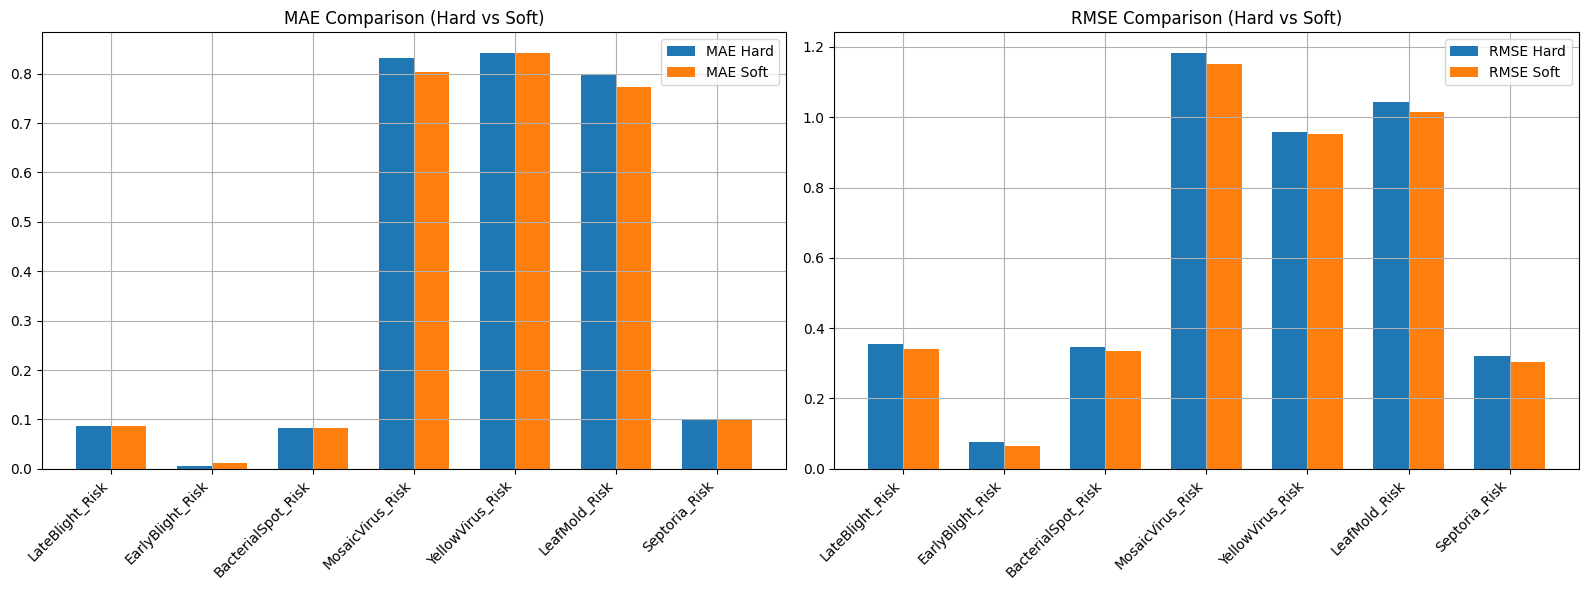

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Bar plot for MAE and RMSE (Hard vs Soft) per disease
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# --- MAE ---
x = np.arange(len(reg_df["Disease"]))
width = 0.35

ax[0].bar(x - width/2, reg_df["MAE_hard"], width, label="MAE Hard")
ax[0].bar(x + width/2, reg_df["MAE_soft"], width, label="MAE Soft")
ax[0].set_title("MAE Comparison (Hard vs Soft)")
ax[0].set_xticks(x)
ax[0].set_xticklabels(reg_df["Disease"], rotation=45, ha='right')
ax[0].legend()
ax[0].grid(True)

# --- RMSE ---
ax[1].bar(x - width/2, reg_df["RMSE_hard"], width, label="RMSE Hard")
ax[1].bar(x + width/2, reg_df["RMSE_soft"], width, label="RMSE Soft")
ax[1].set_title("RMSE Comparison (Hard vs Soft)")
ax[1].set_xticks(x)
ax[1].set_xticklabels(reg_df["Disease"], rotation=45, ha='right')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


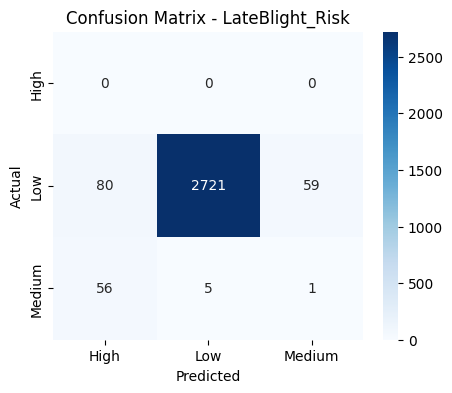

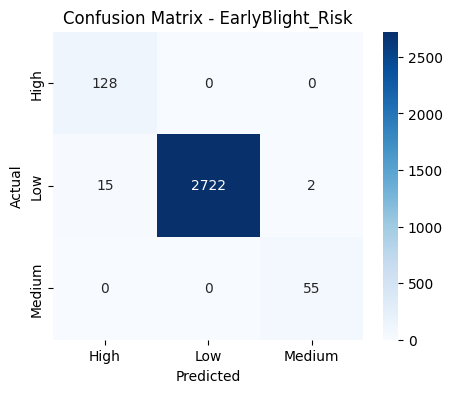

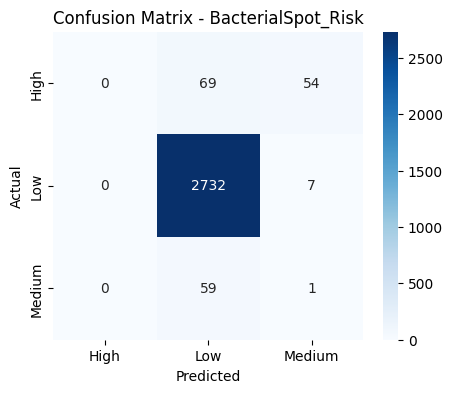

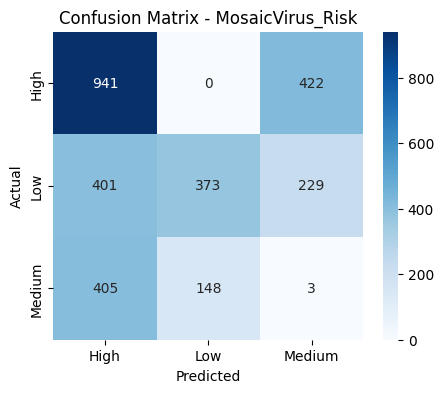

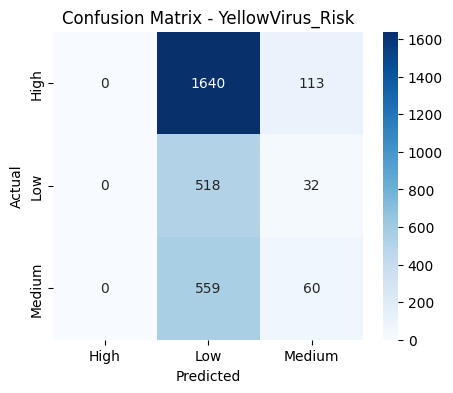

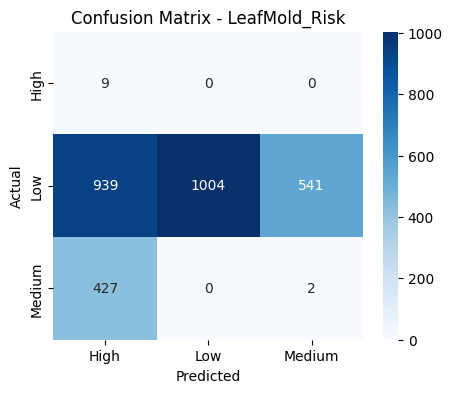

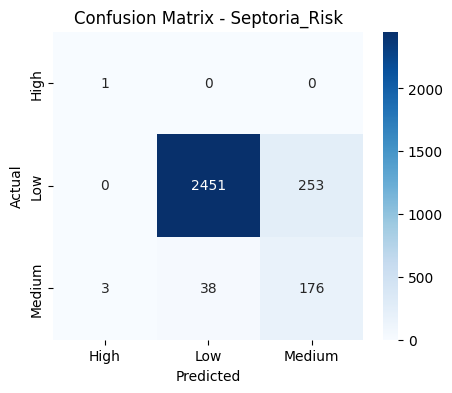

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

for col in target_cols:
    cm = confusion_matrix(y_test[col], y_pred[col])

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt="d",
                xticklabels=encoders[col].classes_,
                yticklabels=encoders[col].classes_)

    plt.title(f"Confusion Matrix - {col}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


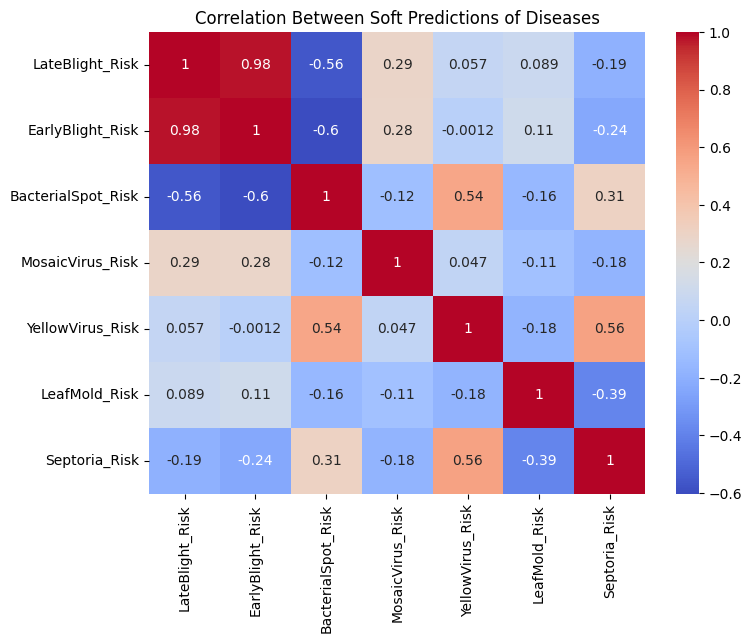

In [ ]:
import pandas as pd

soft_df = {}

for col in target_cols:
    soft_df[col] = (y_pred_probs[col] * np.array([0,1,2])).sum(axis=1)

soft_df = pd.DataFrame(soft_df)

plt.figure(figsize=(8,6))
sns.heatmap(soft_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Soft Predictions of Diseases")
plt.show()


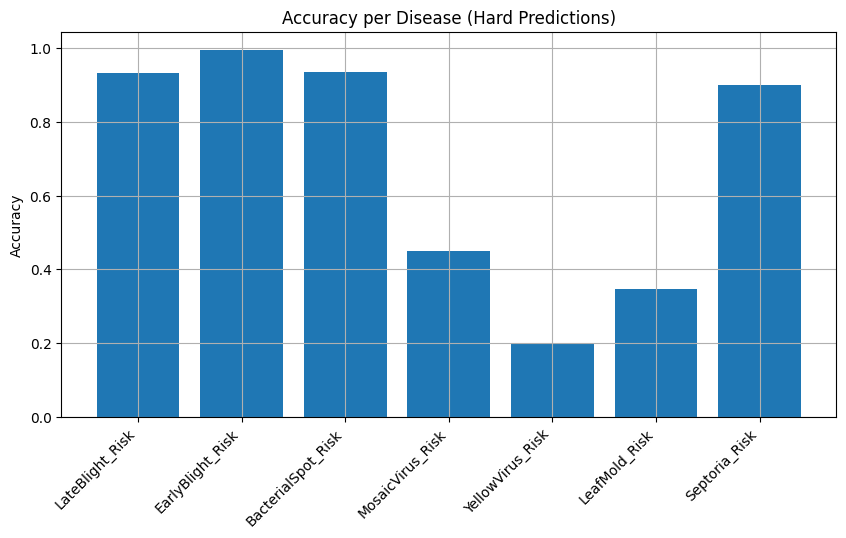

In [ ]:
accuracies = []

for col in target_cols:
    correct = (y_pred[col] == y_test[col].values).mean()
    accuracies.append(correct)

plt.figure(figsize=(10,5))
plt.bar(target_cols, accuracies)
plt.xticks(rotation=45, ha='right')
plt.title("Accuracy per Disease (Hard Predictions)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [ ]:
model_path = "/content/drive/MyDrive/pakistan_tomato_disease_model.h5"
model.save(model_path)

print("Model saved to:", model_path)


Model saved to: /content/drive/MyDrive/pakistan_tomato_disease_model.h5
